# 1. Project Setup & Environment

### Overview
We begin by setting up our environment. This includes importing the necessary PyTorch libraries for deep learning, Torchvision for image transformations, and PIL for image processing.

### Reproducibility
To ensure our results are consistent and reproducible, we define a `set_seed` function. This locks the random number generators for Python, NumPy, and PyTorch to a fixed seed (42).

**Key Libraries:**
* `torch`: The core deep learning framework.
* `torchvision`: Contains datasets, model architectures (like Inception-V3), and image transformations.
* `PIL` & `base64`: For handling the image decoding from the JSONL format.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights

from PIL import Image
import numpy as np
import pandas as pd
import json
import base64
from io import BytesIO
import os
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
import torch.autograd as autograd

warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Set random seeds for reproducibility
SEED = 42
def set_seed(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

PyTorch version: 2.8.0+cu126
CUDA device: Tesla T4


# 2. Data Pipeline: Loading & Preprocessing

### Overview
The competition data is provided in "shards" (folders containing `data.jsonl` files). We need a custom `Dataset` class to handle this efficiently.

### Key Preprocessing Steps
1.  **Decoding:** Images are stored as Base64 strings inside JSON objects. We decode these back into pixel data.
2.  **EXIF Correction:** We apply EXIF rotation tags to ensure images are oriented correctly.
3.  **Color Conversion:** We convert all images (including Grayscale `I;16` and Transparent `RGBA`) to standard 3-channel `RGB`.
4.  **Normalization:**
    * **Resize:** All images are resized to **32x32** pixels using high-quality LANCZOS resampling.
    * **Scale:** Pixel values are scaled from `[0, 255]` to **`[-1, 1]`**. This specific range is critical for GAN stability when using a `Tanh` activation function in the generator.

Loading image shards...


Processing shards:   0%|          | 0/60 [00:00<?, ?it/s]

Successfully loaded 58578 images


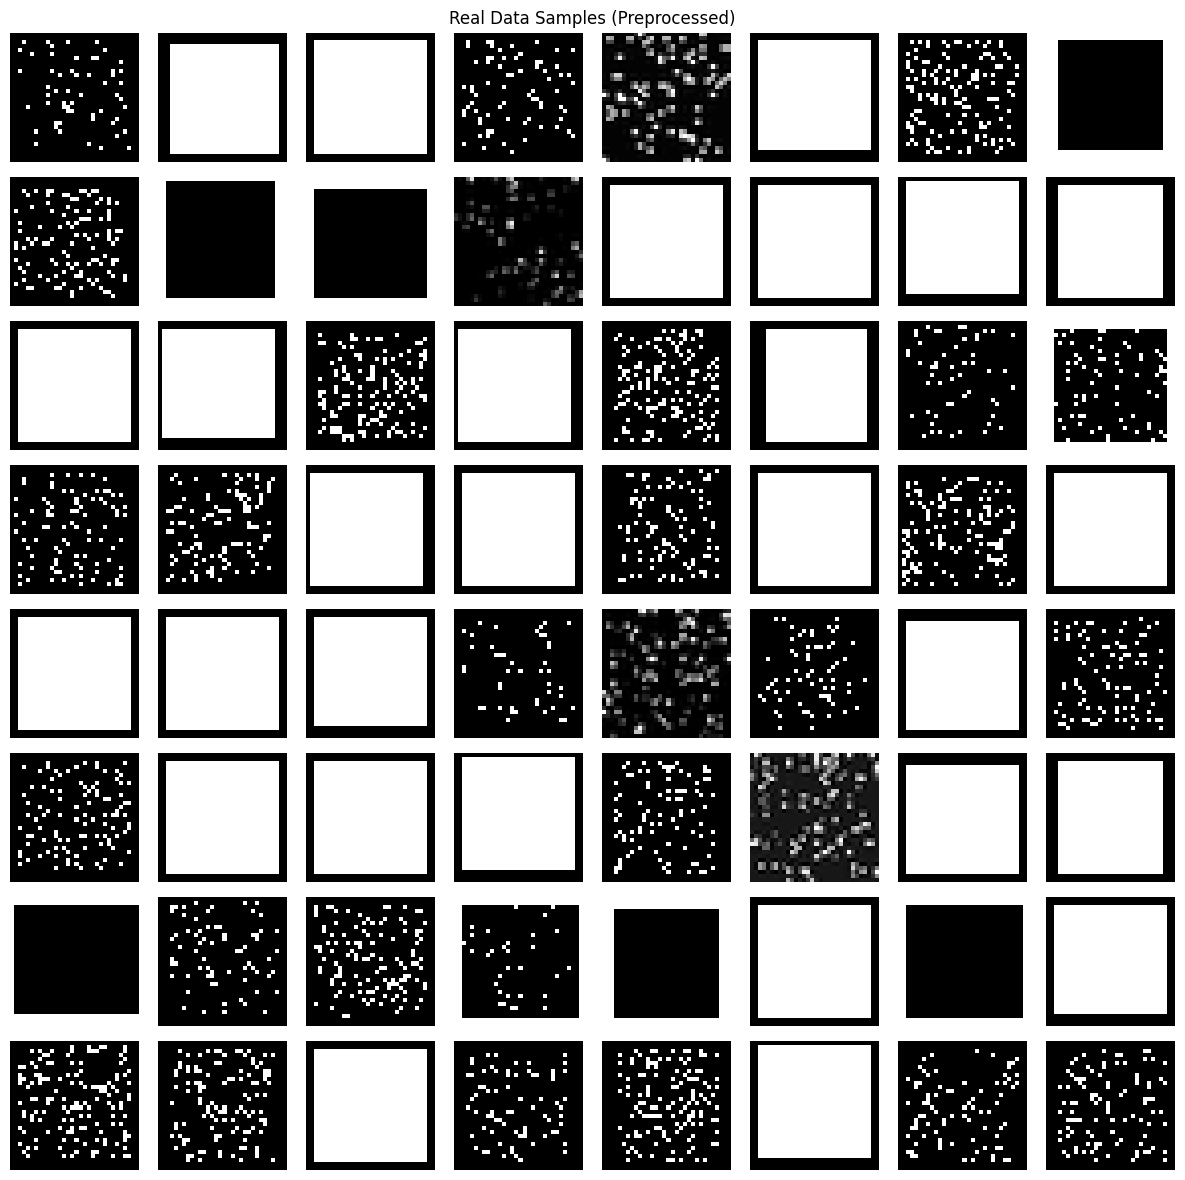

In [2]:
class ImageShardDataset(Dataset):
    """Dataset for loading and preprocessing image shards according to competition specs"""
    
    def __init__(self, shard_dir, transform=None, max_images=None):
        self.shard_dir = Path(shard_dir)
        self.transform = transform
        self.images = []
        self.max_images = max_images
        self.load_all_shards()
    
    def load_all_shards(self):
            print("Loading image shards...")
            shard_dirs = sorted(self.shard_dir.glob("shard_*"))
            
            for shard_dir in tqdm(shard_dirs, desc="Processing shards"):
                if not shard_dir.is_dir(): continue
                try:
                    jsonl_file = shard_dir / "data.jsonl"
                    if jsonl_file.exists():
                        with open(jsonl_file, 'r', encoding='utf-8') as f:
                            for line in f:
                                if self.max_images and len(self.images) >= self.max_images: break
                                try:
                                    data = json.loads(line)
                                    img = self.decode_image(data)
                                    if img is not None: self.images.append(img)
                                except: continue
                except: continue
                if self.max_images and len(self.images) >= self.max_images: break
            print(f"Successfully loaded {len(self.images)} images")
        
    def decode_image(self, data):
        try:
            img_b64 = data.get('img_b64') or data.get('img64')
            if not img_b64: return None
            
            img = Image.open(BytesIO(base64.b64decode(img_b64)))
            mode = data.get('mode', 'RGB')
            
            if mode == 'I;16': img = img.convert('L').convert('RGB')
            elif mode == 'RGBA':
                if data.get('alpha_b64'):
                    try:
                        alpha = Image.open(BytesIO(base64.b64decode(data['alpha_b64']))).convert('L')
                        img.putalpha(alpha)
                    except: pass
                if img.mode == 'RGBA':
                    bbox = img.getbbox()
                    if bbox: img = img.crop(bbox)
                img = img.convert('RGB')
            elif mode != 'RGB': img = img.convert('RGB')
            
            rot = data.get('exif_rot', 0)
            if rot: img = img.rotate(-rot, expand=True)
            if data.get('invert', False): img = Image.eval(img, lambda x: 255 - x)
            
            img = img.resize((32, 32), Image.Resampling.LANCZOS)
            img_array = np.array(img).astype(np.float32)
            return (img_array / 127.5) - 1.0
            
        except: return None
    
    def __len__(self): return len(self.images)
    def __getitem__(self, idx):
        img_tensor = torch.FloatTensor(self.images[idx]).permute(2, 0, 1)
        if self.transform: img_tensor = self.transform(img_tensor)
        return img_tensor

# Load Dataset
SHARD_DIR = '/kaggle/input/test-gan-competition'  # Update path!
dataset = ImageShardDataset(SHARD_DIR, max_images=None)

# Verification Visualization
def show_samples(dataset, num_samples=64):
    fig, axes = plt.subplots(8, 8, figsize=(12, 12)) 
    axes = axes.flatten()
    for i in range(min(num_samples, len(dataset))):
        img = (dataset[i] + 1) / 2
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.suptitle("Real Data Samples (Preprocessed)")
    plt.tight_layout()
    plt.show()

show_samples(dataset)

# 3. Model Architecture: WGAN-GP

### The Generator
The Generator takes a random noise vector (`nz=100`) and upsamples it into a 32x32 image.
* **Layers:** We use `ConvTranspose2d` layers for upsampling.
* **Normalization:** We use `InstanceNorm2d` instead of the traditional `BatchNorm2d`. This is often more stable for WGAN-GP training as it doesn't depend on batch statistics.
* **Activation:** `ReLU` for internal layers, and `Tanh` for the output to bound pixel values between [-1, 1].

### The Discriminator (Critic)
The Discriminator acts as a "Critic" in the WGAN framework. It outputs a continuous score indicating how "real" an image is, rather than a probability.
* **Layers:** Standard `Conv2d` layers with stride 2 for downsampling.
* **Activation:** `LeakyReLU` to prevent "dead ReLU" problems.
* **Output:** A raw scalar value (no Sigmoid activation).

In [3]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: nz x 1 x 1 -> ngf*8 x 4 x 4
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.InstanceNorm2d(ngf * 8), nn.ReLU(True),
            # -> ngf*4 x 8 x 8
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf * 4), nn.ReLU(True),
            # -> ngf*2 x 16 x 16
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf * 2), nn.ReLU(True),
            # -> ngf x 32 x 32
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ngf), nn.ReLU(True),
            # -> nc x 32 x 32
            nn.Conv2d(ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, input): return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # nc x 32 x 32 -> ndf x 16 x 16
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # -> ndf*2 x 8 x 8
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 2), nn.LeakyReLU(0.2, inplace=True),
            # -> ndf*4 x 4 x 4
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4), nn.LeakyReLU(0.2, inplace=True),
            # -> ndf*8 x 2 x 2
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 8), nn.LeakyReLU(0.2, inplace=True),
            # -> 1 x 1 x 1
            nn.Conv2d(ndf * 8, 1, 2, 1, 0, bias=False)
        )
    def forward(self, input): return self.main(input).view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1: nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 4. Hyperparameters & Gradient Penalty

Here we define the training configuration. WGAN-GP relies on a specific loss function that penalizes the gradient norm of the discriminator to enforce the Lipschitz constraint (ensuring stable training).

* **Learning Rate:** `0.0001` (Standard for WGAN-GP)
* **Betas:** `(0.5, 0.9)` for Adam optimizer.
* **Gradient Penalty:** Calculated by interpolating between real and fake images and computing gradients.

In [4]:
# Hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 200  
NZ, NGF, NDF, NC = 100, 16, 16, 3
LEARNING_RATE = 0.0001
BETA1_GP, BETA2_GP = 0.5, 0.9

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

# Initialize models
netG = Generator(NZ, NGF, NC).to(device)
netD = Discriminator(NC, NDF).to(device)
netG.apply(weights_init); netD.apply(weights_init)

# Optimizers
optimizerG = optim.Adam(netG.parameters(), lr=LEARNING_RATE, betas=(BETA1_GP, BETA2_GP))
optimizerD = optim.Adam(netD.parameters(), lr=LEARNING_RATE, betas=(BETA1_GP, BETA2_GP))

def compute_gradient_penalty(netD, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = netD(interpolates)
    fake = torch.full((real_samples.size(0),), 1.0, dtype=torch.float, device=device)
    gradients = autograd.grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=fake,
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# 5. Training Loop (Visual Logs Only)

We now train the model for 200 epochs. 

### Training Dynamics
* **Discriminator Updates:** We train the discriminator 5 times for every 1 generator update. This is crucial for WGAN to maintain a good estimate of the Wasserstein distance.
* **Visualization:** To keep the output clean, we suppress numerical logs. Instead, **every 10 epochs**, we generate a grid of 16 images using a fixed noise vector. This allows us to visually inspect the generator's progress over time.

Starting Training (Visual Logs Only)...


Epoch 1/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 6/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/915 [00:00<?, ?it/s]

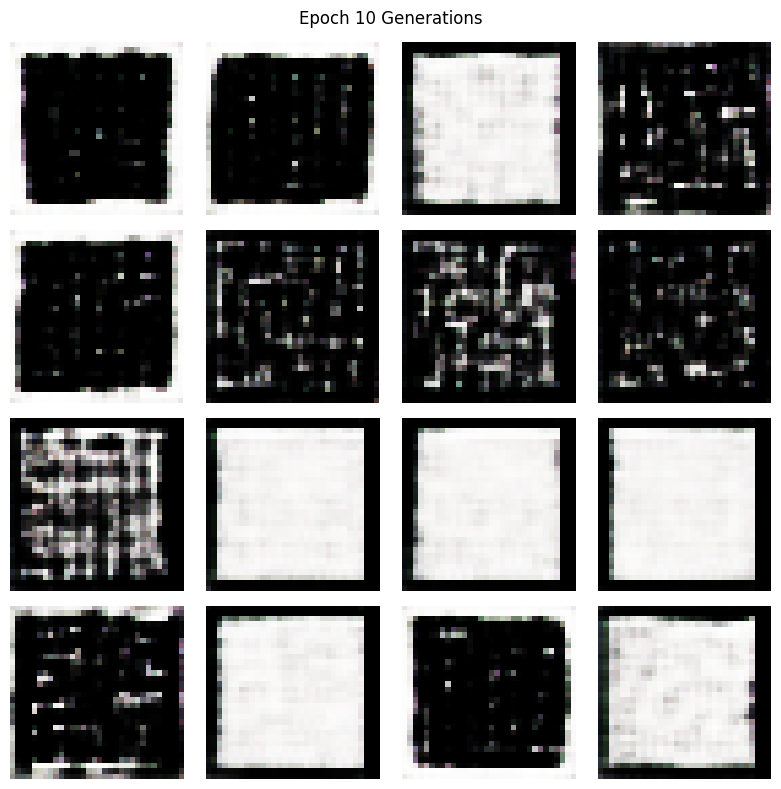

Epoch 11/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 16/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/915 [00:00<?, ?it/s]

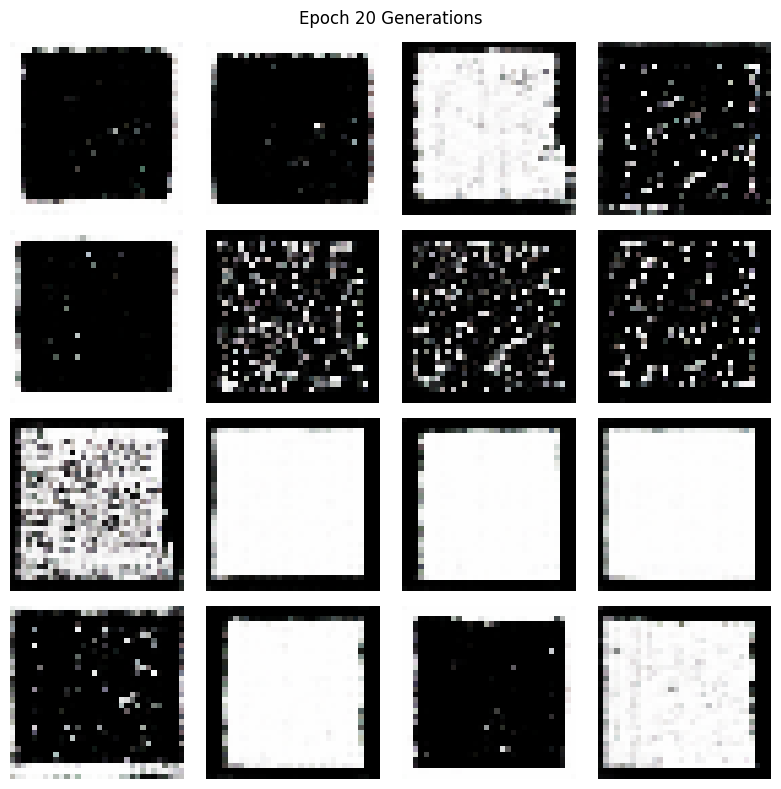

Epoch 21/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 26/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/915 [00:00<?, ?it/s]

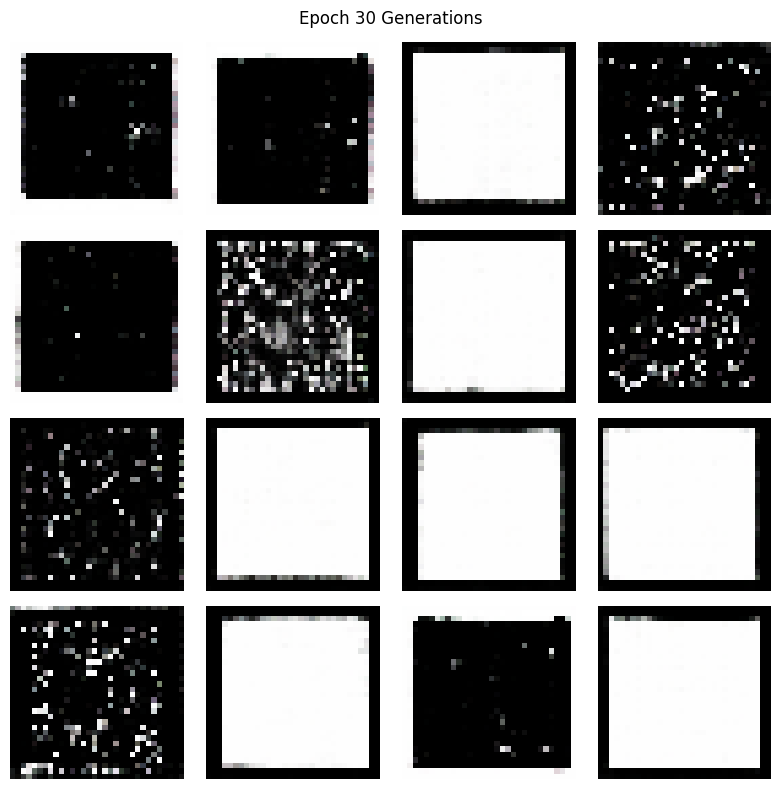

Epoch 31/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 33/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 34/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 35/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 36/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 37/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 38/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 39/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 40/200:   0%|          | 0/915 [00:00<?, ?it/s]

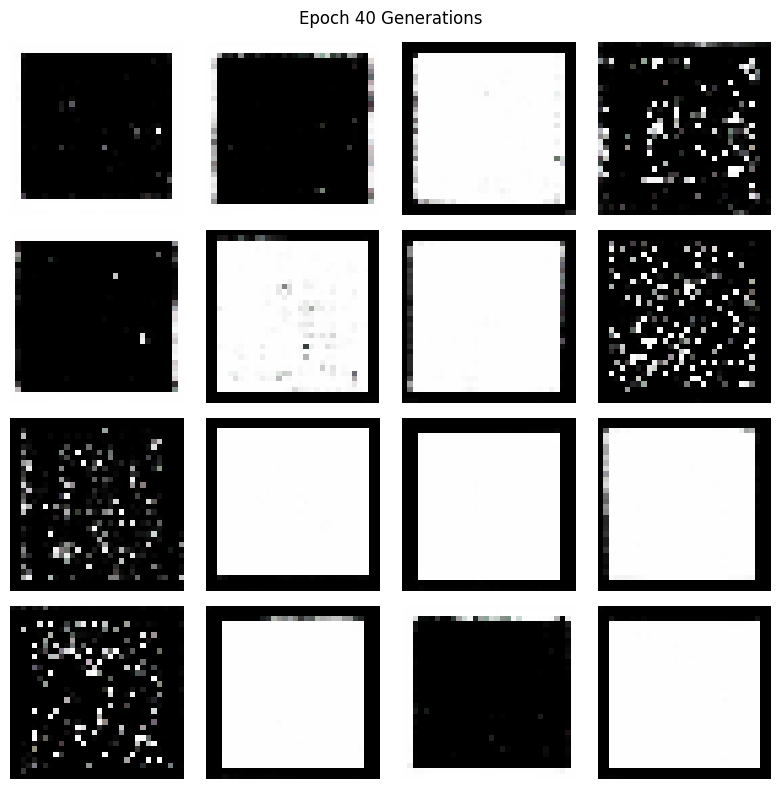

Epoch 41/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 42/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 43/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 44/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 45/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 46/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 47/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 48/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 49/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 50/200:   0%|          | 0/915 [00:00<?, ?it/s]

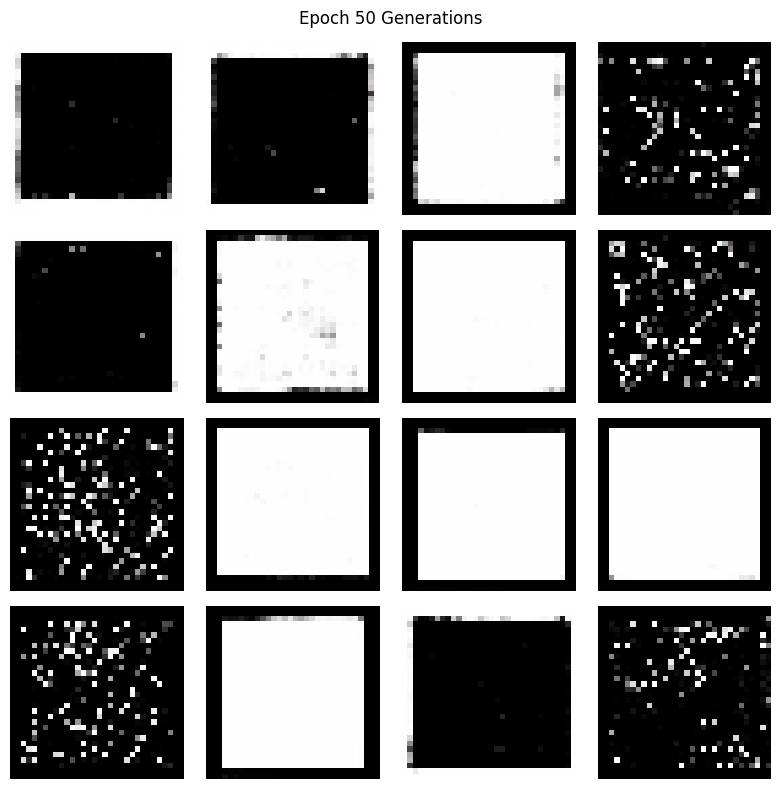

Epoch 51/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 52/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 53/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 54/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 55/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 56/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 57/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 58/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 59/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 60/200:   0%|          | 0/915 [00:00<?, ?it/s]

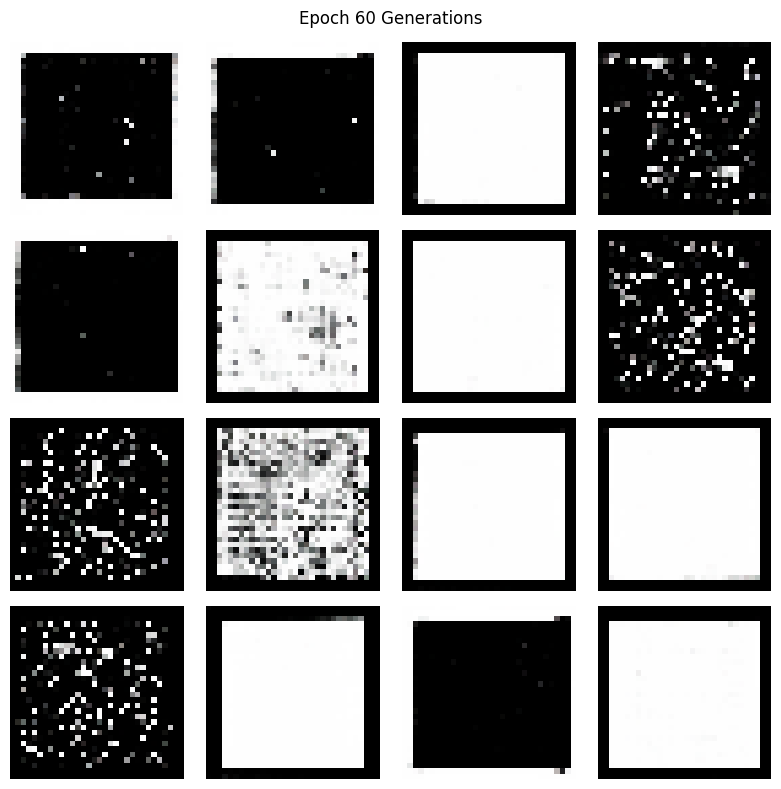

Epoch 61/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 62/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 63/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 64/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 65/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 66/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 67/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 68/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 69/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 70/200:   0%|          | 0/915 [00:00<?, ?it/s]

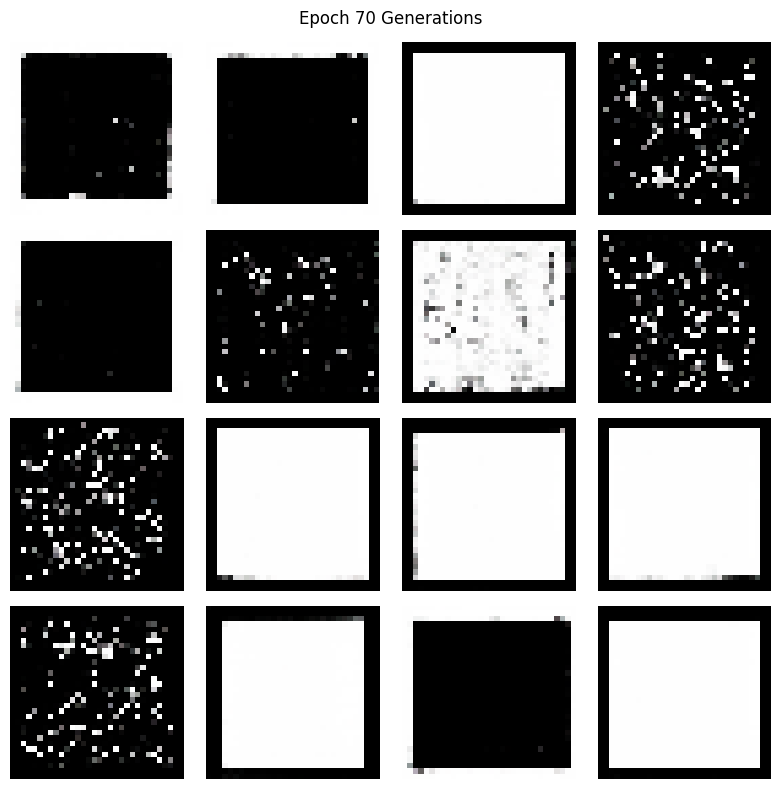

Epoch 71/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 72/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 73/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 74/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 75/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 76/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 77/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 78/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 79/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 80/200:   0%|          | 0/915 [00:00<?, ?it/s]

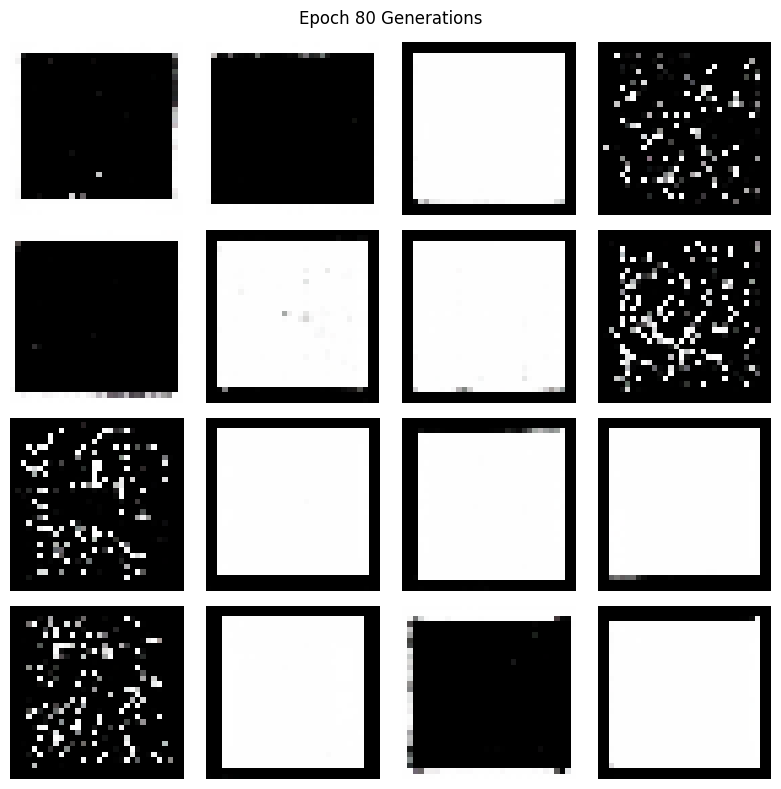

Epoch 81/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 82/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 83/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 84/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 85/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 86/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 87/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 88/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 89/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 90/200:   0%|          | 0/915 [00:00<?, ?it/s]

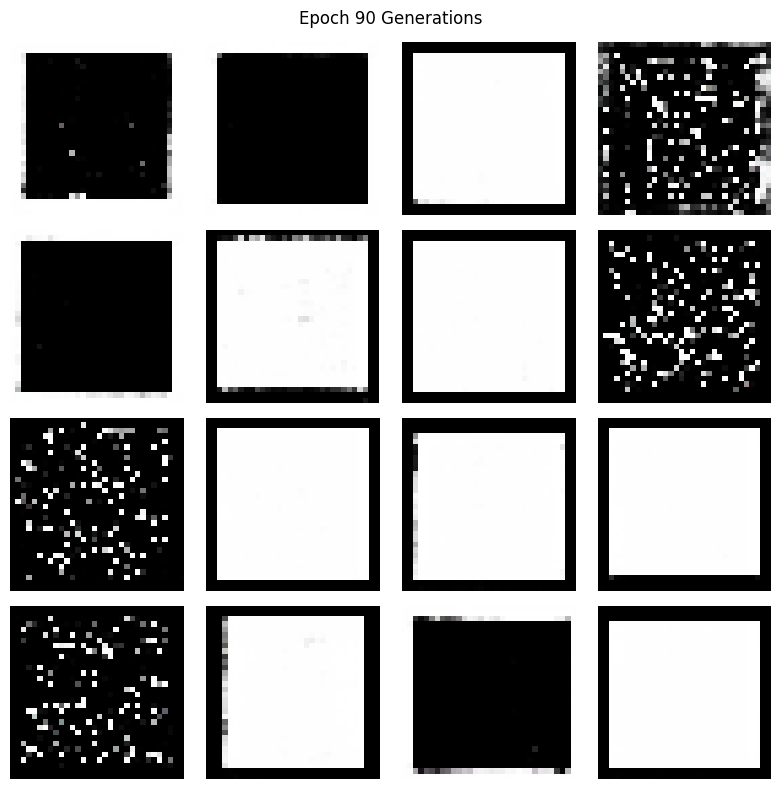

Epoch 91/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 92/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 93/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 94/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 95/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 96/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 97/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 98/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 99/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 100/200:   0%|          | 0/915 [00:00<?, ?it/s]

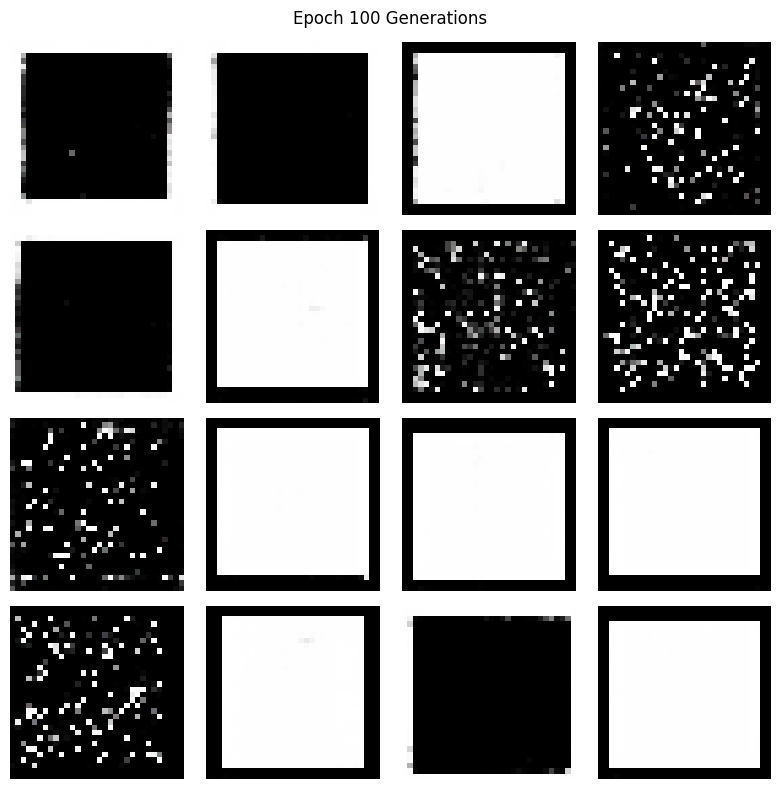

Epoch 101/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 102/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 103/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 104/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 105/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 106/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 107/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 108/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 109/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 110/200:   0%|          | 0/915 [00:00<?, ?it/s]

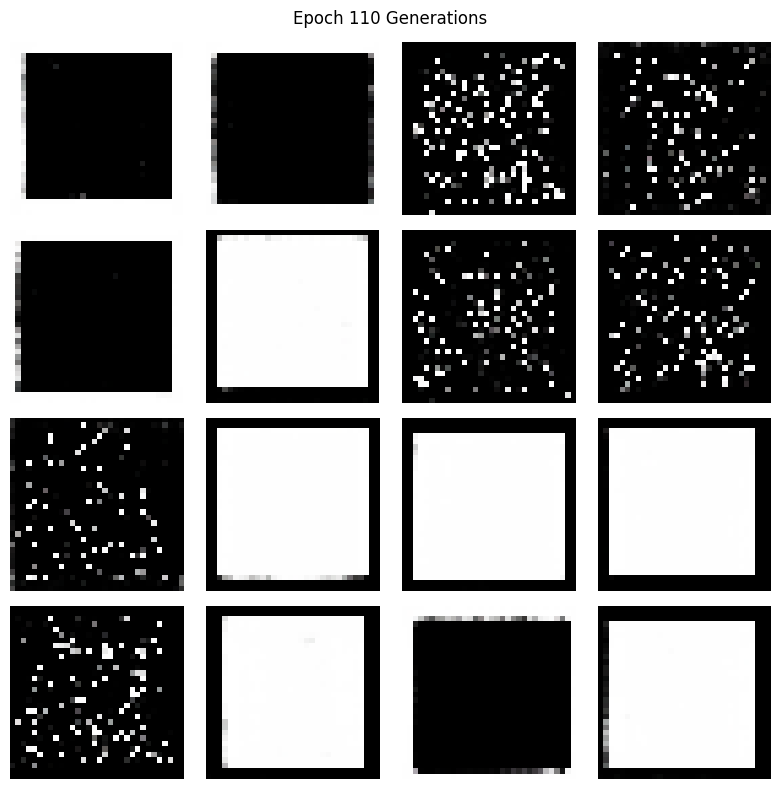

Epoch 111/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 112/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 113/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 114/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 115/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 116/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 117/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 118/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 119/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 120/200:   0%|          | 0/915 [00:00<?, ?it/s]

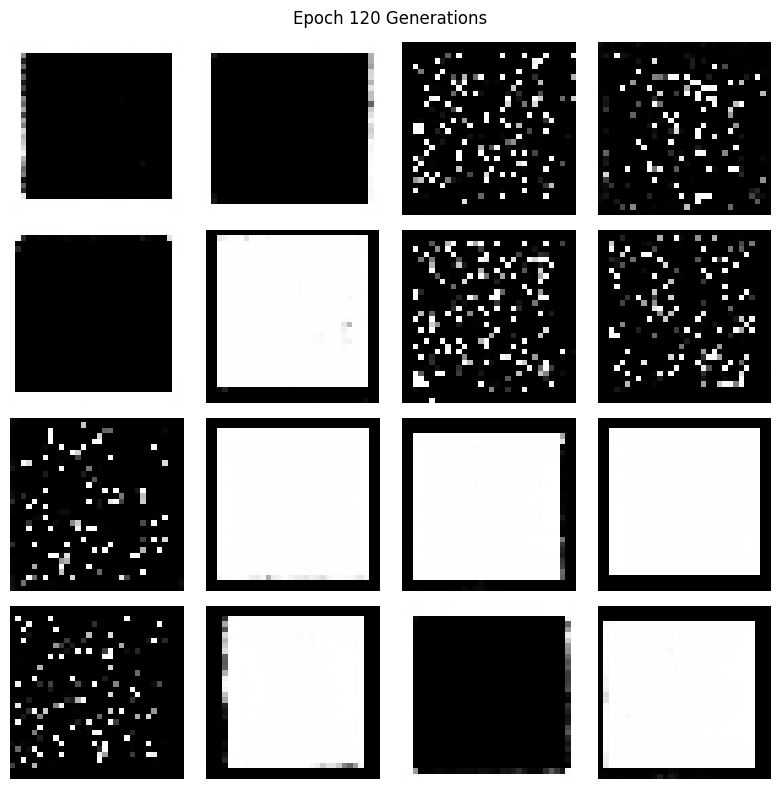

Epoch 121/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 122/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 123/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 124/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 125/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 126/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 127/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 128/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 129/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 130/200:   0%|          | 0/915 [00:00<?, ?it/s]

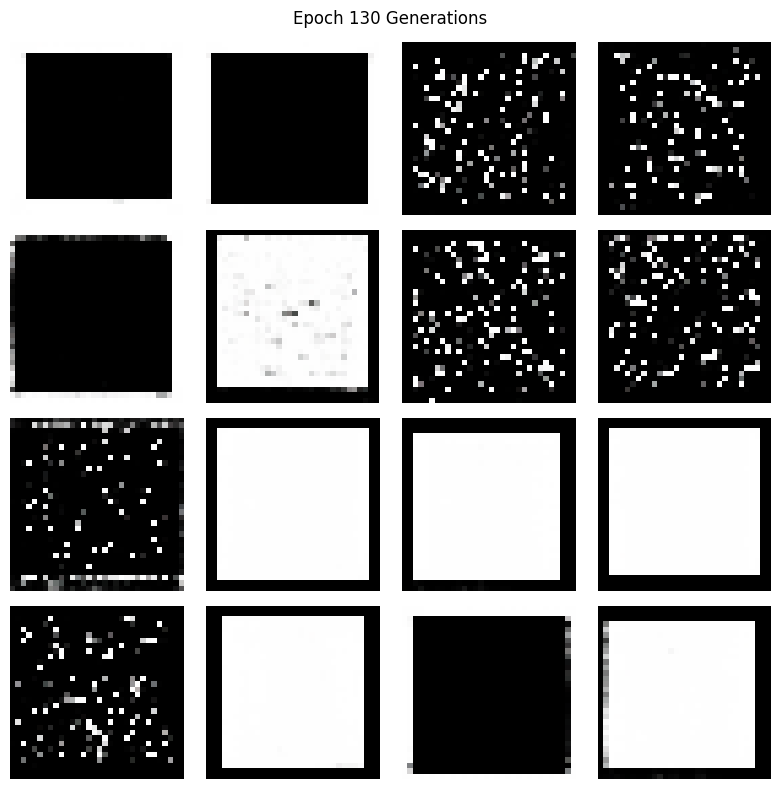

Epoch 131/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 132/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 133/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 134/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 135/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 136/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 137/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 138/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 139/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 140/200:   0%|          | 0/915 [00:00<?, ?it/s]

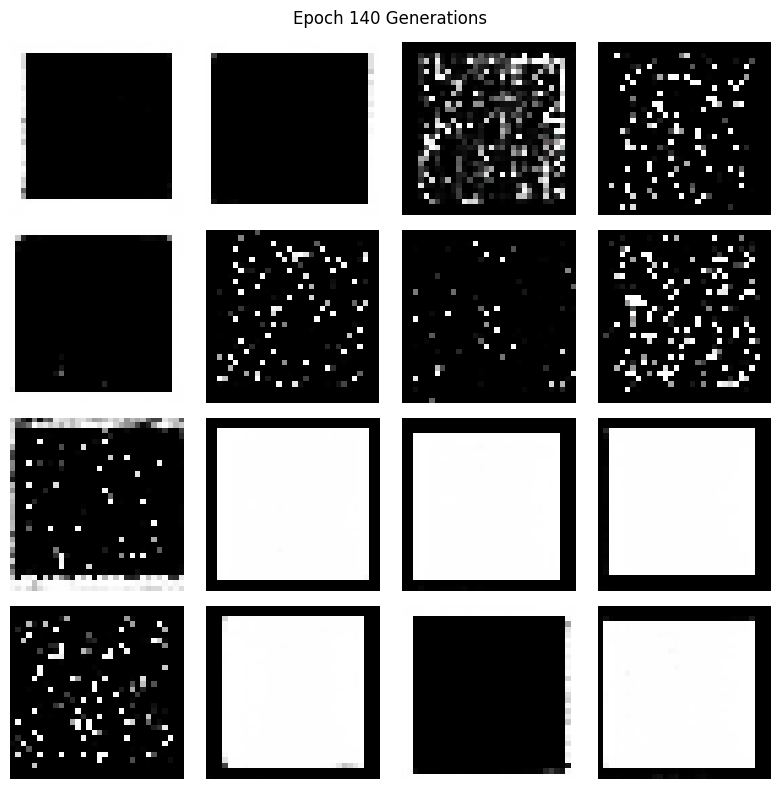

Epoch 141/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 142/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 143/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 144/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 145/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 146/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 147/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 148/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 149/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 150/200:   0%|          | 0/915 [00:00<?, ?it/s]

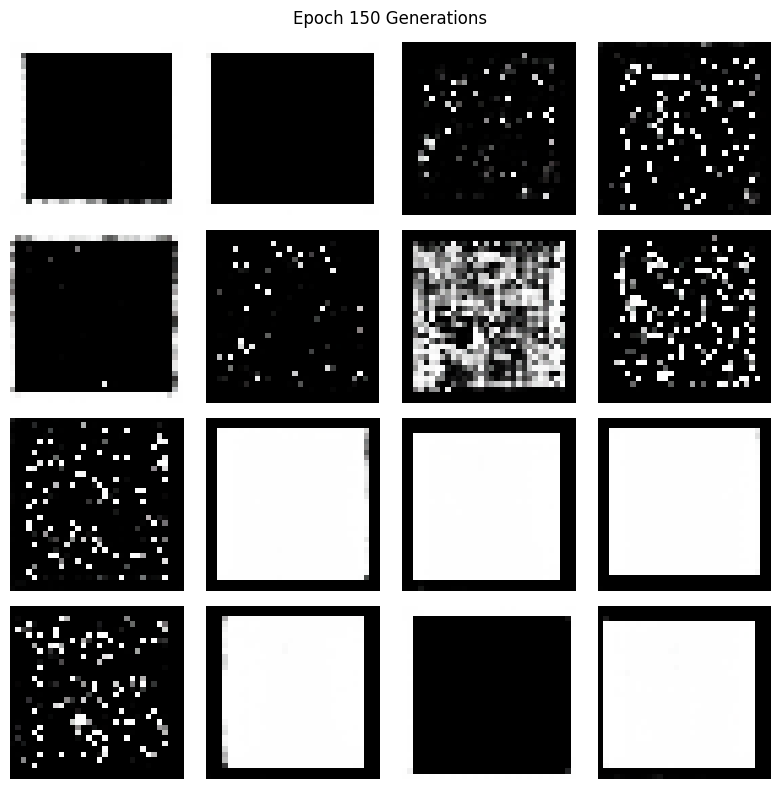

Epoch 151/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 152/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 153/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 154/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 155/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 156/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 157/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 158/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 159/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 160/200:   0%|          | 0/915 [00:00<?, ?it/s]

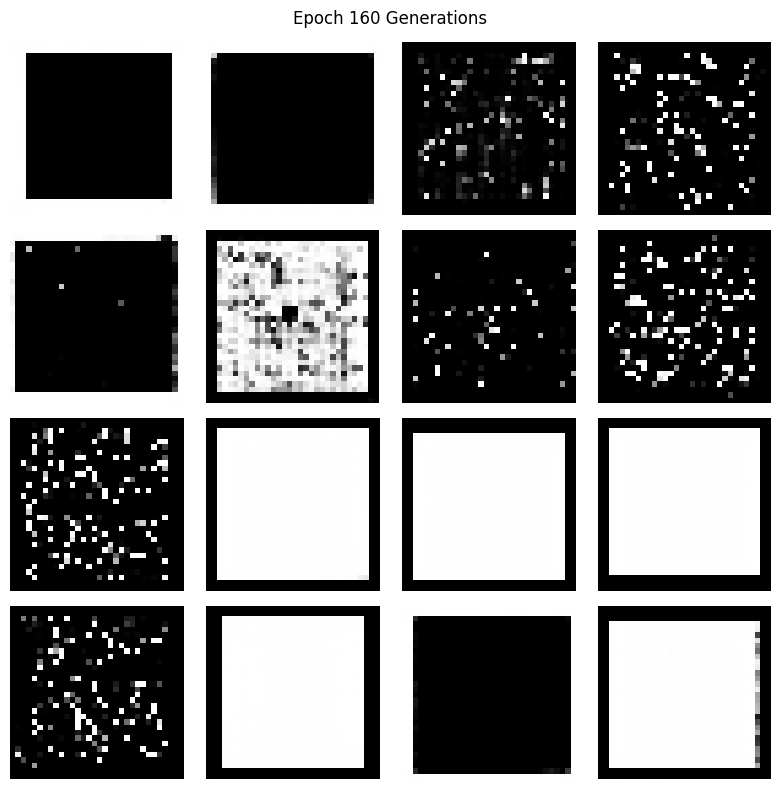

Epoch 161/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 162/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 163/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 164/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 165/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 166/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 167/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 168/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 169/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 170/200:   0%|          | 0/915 [00:00<?, ?it/s]

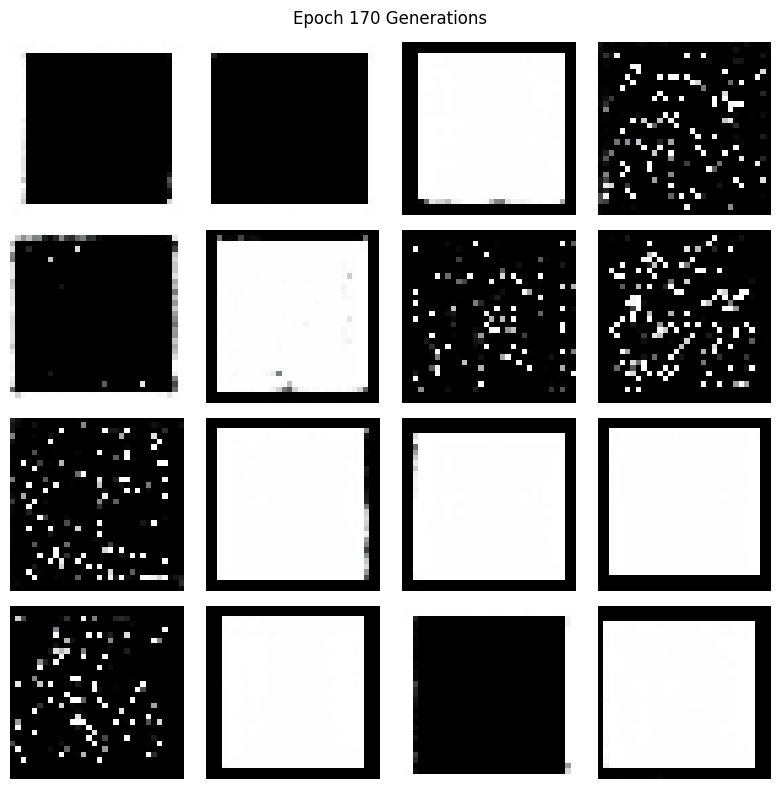

Epoch 171/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 172/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 173/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 174/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 175/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 176/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 177/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 178/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 179/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 180/200:   0%|          | 0/915 [00:00<?, ?it/s]

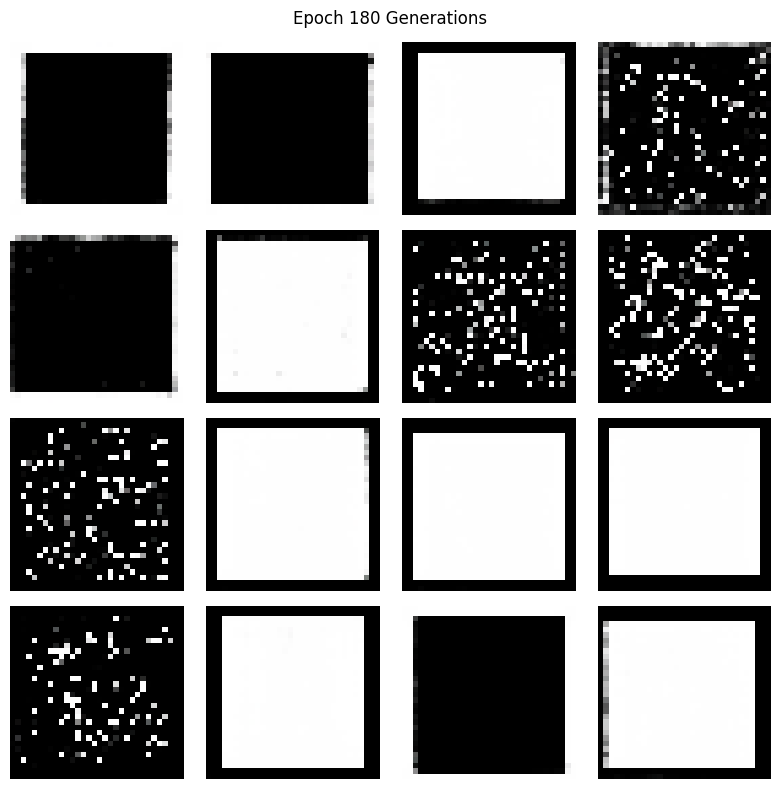

Epoch 181/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 182/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 183/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 184/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 185/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 186/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 187/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 188/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 189/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 190/200:   0%|          | 0/915 [00:00<?, ?it/s]

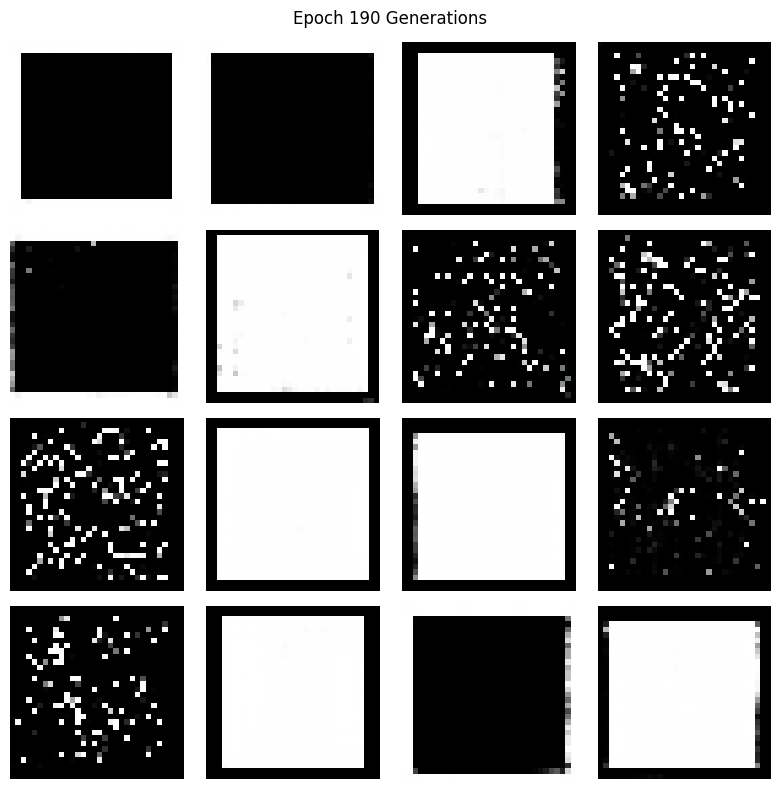

Epoch 191/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 192/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 193/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 194/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 195/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 196/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 197/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 198/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 199/200:   0%|          | 0/915 [00:00<?, ?it/s]

Epoch 200/200:   0%|          | 0/915 [00:00<?, ?it/s]

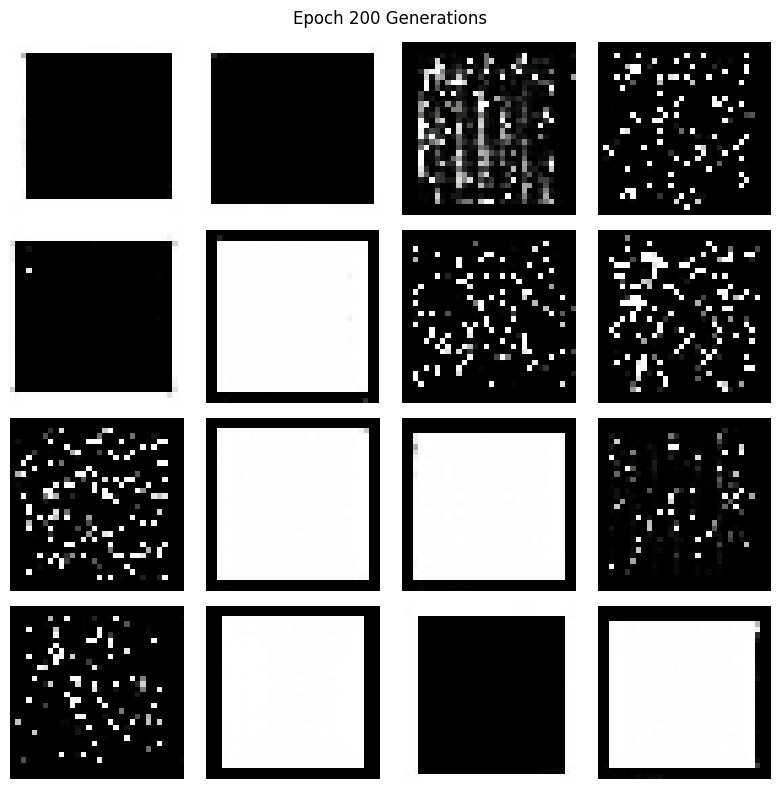

In [5]:
def train_gan(num_epochs=NUM_EPOCHS):
    CHECKPOINT_DIR = "checkpoints_wgangp"
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    
    G_losses, D_losses = [], []
    fixed_noise = torch.randn(64, NZ, 1, 1, device=device)
    lambda_gp, critic_iterations = 10, 5
    
    print("Starting Training (Visual Logs Only)...")
    
    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0
        
        for i, data in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)):
            
            # --- Train Critic ---
            netD.zero_grad()
            real_batch = data.to(device)
            noise = torch.randn(real_batch.size(0), NZ, 1, 1, device=device)
            fake = netG(noise)
            
            errD = netD(fake.detach()).mean() - netD(real_batch).mean() + \
                   (lambda_gp * compute_gradient_penalty(netD, real_batch.data, fake.data))
            errD.backward()
            optimizerD.step()
            epoch_d_loss += errD.item()

            # --- Train Generator ---
            if i % critic_iterations == 0:
                netG.zero_grad()
                errG = -netD(fake).mean()
                errG.backward()
                optimizerG.step()
                epoch_g_loss += errG.item()
        
        G_losses.append(epoch_g_loss / (len(dataloader) / critic_iterations))
        D_losses.append(epoch_d_loss / len(dataloader))
        
        # --- VISUALIZATION BLOCK (Runs every 10 epochs) ---
        if (epoch + 1) % 10 == 0:
            with torch.no_grad():
                netG.eval()
                fake_images = netG(fixed_noise)
                fake_images = (fake_images + 1) / 2
                
                fig, axes = plt.subplots(4, 4, figsize=(8, 8))
                axes = axes.flatten()
                for j in range(16):
                    img = fake_images[j].cpu().permute(1, 2, 0).numpy()
                    axes[j].imshow(img)
                    axes[j].axis('off')
                plt.suptitle(f'Epoch {epoch+1} Generations')
                plt.tight_layout()
                plt.show()
                netG.train()
                
            torch.save(netG.state_dict(), os.path.join(CHECKPOINT_DIR, f"netG_epoch_{epoch+1}.pth"))

    return G_losses, D_losses
    
G_losses, D_losses = train_gan(NUM_EPOCHS)

# 6. Feature Extraction with Inception-V3

The competition requires a submission file containing features extracted from our generated images. We use a pre-trained **Inception-V3** model for this purpose.

* **Layer:** We extract the output from the final pooling layer (2048-dimensional vector).
* **Preprocessing:** The images are resized to 299x299 (required by Inception) and normalized using ImageNet statistics.

In [6]:
def extract_inception_features(images):
    print("Loading Inception-V3...")
    model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    model.fc = nn.Identity()
    model.eval()
    if torch.cuda.is_available(): model = model.cuda()
    
    preprocess = transforms.Compose([
        transforms.ToPILImage(), transforms.Resize((299, 299)),
        transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    features = []
    print("Extracting features...")
    # Convert list of arrays to tensor batches for speed
    # Note: Processing one by one for simplicity/memory safety
    for img in tqdm(images):
        # Image is (32, 32, 3) numpy array [0, 255]
        img_tensor = preprocess(img).unsqueeze(0)
        if torch.cuda.is_available(): img_tensor = img_tensor.cuda()
        
        with torch.no_grad():
            feat = model(img_tensor)
            if isinstance(feat, tuple): feat = feat[0]
            features.append(feat.squeeze().cpu().numpy())
    
    return np.array(features)

# 7. Final Generation & Submission

We now perform the final steps to create our submission file:
1.  **Generate:** We create 1,000 new, random images using our trained generator.
2.  **Extract:** We pass these 1,000 images through the Inception-V3 model.
3.  **Save:** We structure the features into a DataFrame with columns `f0` through `f2047` and save it as `submission.csv`.

In [7]:
def generate_samples(num_samples=1000, seed=42):
    netG.eval()
    set_seed(seed)
    generated_images = []
    
    with torch.no_grad():
        batch_size = 50
        for _ in tqdm(range(num_samples // batch_size), desc="Generating"):
            noise = torch.randn(batch_size, NZ, 1, 1, device=device)
            fake = ((netG(noise) + 1) * 127.5).clamp(0, 255).byte()
            for img in fake.cpu().numpy():
                generated_images.append(np.transpose(img, (1, 2, 0)))
    
    return generated_images

# 1. Generate Images
gen_images = generate_samples(1000)

# 2. Extract Features
features = extract_inception_features(gen_images)

# 3. Create Submission
ids = [f"dig-{i:06d}" for i in range(len(features))]
df = pd.DataFrame(features, columns=[f"f{i}" for i in range(2048)])
df.insert(0, "id", ids)
df.to_csv('submission.csv', index=False)

print(f"✅ Submission saved with shape {df.shape}")
print(df.head())

Generating:   0%|          | 0/20 [00:00<?, ?it/s]

Loading Inception-V3...
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 187MB/s] 


Extracting features...


  0%|          | 0/1000 [00:00<?, ?it/s]

✅ Submission saved with shape (1000, 2049)
           id        f0        f1        f2        f3        f4        f5  \
0  dig-000000  0.608264  0.046868  0.001124  0.180319  0.000814  0.016884   
1  dig-000001  0.268324  0.011422  0.000000  0.275551  0.000000  0.000000   
2  dig-000002  0.442727  0.017039  0.163949  0.084657  0.002862  0.526866   
3  dig-000003  0.082325  0.025327  0.000000  0.307368  0.005307  0.002140   
4  dig-000004  0.086159  0.111921  0.067497  0.006002  0.010090  0.075380   

         f6        f7        f8  ...     f2038     f2039     f2040     f2041  \
0  0.874365  1.665908  0.029260  ...  0.074171  0.403518  0.892026  0.760300   
1  1.037135  1.901196  0.049034  ...  0.481971  0.976497  0.348871  0.144987   
2  0.758248  0.030411  0.093877  ...  0.274299  0.189872  0.000490  0.534168   
3  0.957144  2.707033  0.100035  ...  0.547534  1.138242  0.200048  0.174250   
4  0.067706  0.095135  0.020213  ...  0.246865  0.139244  0.093598  2.181793   

      f2042  